In [1]:
import h5py
import iris
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path
plt.rcParams['mathtext.default'] = 'regular'

In [2]:
# Read data
path_to_gfed = Path('../../external_data/GFED')
path_to_ukca = Path('../data')
gfed = iris.load(str(path_to_gfed / 'GFED4.1s_1997-2016_multiyear_monthly_mean_dm_emissions.nc'))
ukca = iris.load_cube(str(path_to_ukca / 'xmeka' / 'xmeka_o3.nc'))

In [3]:
gfed

[<iris 'Cube' of dry matter emissions / (kg/m2/month) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of deforestation and degradation to dry matter emissions / (1) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of grid cell area / (m2) (latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of peatland fires to dry matter emissions / (1) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of boreal forest fires to dry matter emissions / (1) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of agricultural waste burning to dry matter emissions / (1) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of temperate forest fires to dry matter emissions / (1) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of savanna, grassland and shrubland fires to dry matter emissions / (1) (time: 12; 

In [4]:
# Extract GFED dry matter emissions, GFED grid cell area and GFED and UKCA coordinates
dm = gfed.extract_strict('dry matter emissions')
dm_fr_borf = gfed.extract_strict('fractional contribution of boreal forest fires to dry matter emissions')
dm_fr_sava = gfed.extract_strict('fractional contribution of savanna, grassland and shrubland fires to dry matter emissions')
dm_fr_temf = gfed.extract_strict('fractional contribution of temperate forest fires to dry matter emissions')
gfed_grid_cell_area = gfed.extract_strict('grid cell area')
gfed_lats = dm.coord('latitude').points
gfed_lons = dm.coord('longitude').points
ukca_lats = ukca.coord('latitude').points
ukca_lons = ukca.coord('longitude').points

From https://www.geo.vu.nl/~gwerf/GFED/GFED4/ancill/code/get_GFED4s_CO_emissions.py

```python
# calculate CO emissions as the product of DM emissions (kg DM per 
# m2 per month), the fraction the specific source contributes to 
# this (unitless), and the emission factor (g CO per kg DM burned)
CO_emissions += DM_emissions * contribution * EF_CO[source]
```
From Akagi et al. (2011) Table 1 Emission factors (g kg-1) for species emitted from different types of biomass burning. Emission factors are shown with an estimate of the natural variation in parenthesis, when available. Note that boreal and extratropical forest values are the same for C1-C3 RONO2.

| RONO2   | tropical forest       | savanna             | crop residue | pasture maintenance | boreal forest | temperate forest | extratropical forest |
|---------|-----------------------|---------------------|--------------|---------------------|---------------|------------------|----------------------|
| MeONO2  | 8.29×10−3 (1.60×10−2) | 5.1×10−4 (3.7×10−4) | -            | -                   | 2.83×10−3     | -                | 2.83×10−3            |
| EtONO2  | 5.70×10−3             | -                   | -            | -                   | 1.78×10−3     | -                | 1.78×10−3            |
| nPrONO2 | 0.0003                | -                   | -            | -                   | 3.23×10−4     | -                | 3.23×10−4            |
| iPrONO2 | 0.001                 | -                   | -            | -                   | 3.23×10−3     | -                | 3.23×10−3            |

In [5]:
# Akagi et al. (2011) emission factors [g kg]
meono2_ef_trof = iris.coords.AuxCoord(8.29*1e-3, units='g/kg', long_name='methyl nitrate tropical forest fire emission factor')
meono2_ef_sava = iris.coords.AuxCoord(5.1*1e-4, units='g/kg', long_name='methyl nitrate savanna fire emission factor')
meono2_ef_borf = iris.coords.AuxCoord(2.83*1e-3, units='g/kg', long_name='methyl nitrate boreal forest fire emission factor')
etono2_ef_trof = iris.coords.AuxCoord(5.70*1e-3, units='g/kg', long_name='ethyl nitrate tropical forest fire emission factor')
etono2_ef_borf = iris.coords.AuxCoord(1.78*1e-3, units='g/kg', long_name='ethyl nitrate boreal forest fire emission factor')
nprono2_ef_trof = iris.coords.AuxCoord(0.0003, units='g/kg', long_name='npropyl nitrate tropical forest fire emission factor')
nprono2_ef_borf = iris.coords.AuxCoord(3.23*1e-4, units='g/kg', long_name='npropyl nitrate boreal forest fire emission factor')
iprono2_ef_trof = iris.coords.AuxCoord(0.001, units='g/kg', long_name='ipropyl nitrate tropical forest fire emission factor')
iprono2_ef_borf = iris.coords.AuxCoord(3.23*1e-3, units='g/kg', long_name='ipropyl nitrate boreal forest fire emission factor')
# Calculate dry matter emissions from individual sources
dm_borf = dm*dm_fr_borf
dm_sava = dm*dm_fr_sava
dm_temf = dm*dm_fr_temf
dm_borf.convert_units('kg/m2/s')
dm_sava.convert_units('kg/m2/s')
dm_temf.convert_units('kg/m2/s')
# Calculate lower and upper limit of GFED RONO2 biomass burning emissions
gfed_meono2_ll = (dm_borf+dm_temf)*meono2_ef_borf + dm_sava*meono2_ef_sava
gfed_etono2_ll = (dm_borf+dm_temf)*etono2_ef_borf + dm_sava*etono2_ef_trof*(meono2_ef_sava.points[0]/meono2_ef_trof.points[0])
gfed_nprono2_ll = (dm_borf+dm_temf)*nprono2_ef_borf + dm_sava*nprono2_ef_trof*(meono2_ef_sava.points[0]/meono2_ef_trof.points[0])
gfed_iprono2_ll = (dm_borf+dm_temf)*iprono2_ef_borf + dm_sava*iprono2_ef_trof*(meono2_ef_sava.points[0]/meono2_ef_trof.points[0])
gfed_meono2_ul = (dm_borf+dm_temf)*meono2_ef_borf + dm_sava*meono2_ef_trof
gfed_etono2_ul = (dm_borf+dm_temf)*etono2_ef_borf + dm_sava*etono2_ef_trof
gfed_nprono2_ul = (dm_borf+dm_temf)*nprono2_ef_borf + dm_sava*nprono2_ef_trof
gfed_iprono2_ul = (dm_borf+dm_temf)*iprono2_ef_borf + dm_sava*iprono2_ef_trof
gfed_meono2_ll.convert_units('kg/m2/s')
gfed_etono2_ll.convert_units('kg/m2/s')
gfed_nprono2_ll.convert_units('kg/m2/s')
gfed_iprono2_ll.convert_units('kg/m2/s')
gfed_meono2_ul.convert_units('kg/m2/s')
gfed_etono2_ul.convert_units('kg/m2/s')
gfed_nprono2_ul.convert_units('kg/m2/s')
gfed_iprono2_ul.convert_units('kg/m2/s')

In [6]:
gfed_lons[0:20]

array([-179.875, -179.625, -179.375, -179.125, -178.875, -178.625,
       -178.375, -178.125, -177.875, -177.625, -177.375, -177.125,
       -176.875, -176.625, -176.375, -176.125, -175.875, -175.625,
       -175.375, -175.125], dtype=float32)

In [7]:
ukca_lons[0:20]

array([ 0.  ,  3.75,  7.5 , 11.25, 15.  , 18.75, 22.5 , 26.25, 30.  ,
       33.75, 37.5 , 41.25, 45.  , 48.75, 52.5 , 56.25, 60.  , 63.75,
       67.5 , 71.25], dtype=float32)

In [8]:
def roll_cube_w2e(cube_in, inplace=False):
    """Takes a cube which longitudes span -180...180 and rolls them by 180 degrees west to east to 0...360.
    Inspired by https://gist.github.com/dennissergeev/0e362a8a8a8f12b87221c1519b9903cf"""
    if inplace:
        cube = cube_in
    else:
        cube = cube_in.copy()
    lon = cube.coord('longitude')
    if (lon.points < 0.).any():
        add = 180
        cube.data = np.roll(cube.data, len(lon.points) // 2, axis=-1)
        if lon.has_bounds():
            bounds = lon.bounds + add
        else:
            bounds = None
        cube.replace_coord(lon.copy(points=lon.points + add, bounds=bounds))
    if not inplace:
        return cube

In [9]:
# Roll GFED data west to east and regrid it onto UKCA grid
ukca_grid = [('longitude', ukca.coord('longitude').points), ('latitude', ukca.coord('latitude').points)]
ukca_meono2_ll = roll_cube_w2e(gfed_meono2_ll).interpolate(ukca_grid, iris.analysis.Linear())
ukca_etono2_ll = roll_cube_w2e(gfed_etono2_ll).interpolate(ukca_grid, iris.analysis.Linear())
ukca_nprono2_ll = roll_cube_w2e(gfed_nprono2_ll).interpolate(ukca_grid, iris.analysis.Linear())
ukca_iprono2_ll = roll_cube_w2e(gfed_iprono2_ll).interpolate(ukca_grid, iris.analysis.Linear())
ukca_meono2_ul = roll_cube_w2e(gfed_meono2_ul).interpolate(ukca_grid, iris.analysis.Linear())
ukca_etono2_ul = roll_cube_w2e(gfed_etono2_ul).interpolate(ukca_grid, iris.analysis.Linear())
ukca_nprono2_ul = roll_cube_w2e(gfed_nprono2_ul).interpolate(ukca_grid, iris.analysis.Linear())
ukca_iprono2_ul = roll_cube_w2e(gfed_iprono2_ul).interpolate(ukca_grid, iris.analysis.Linear())

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


In [10]:
def plt_map(lons, lats, cb, specie):
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
    p0 = ax.pcolormesh(lons, lats, cb, transform=ccrs.PlateCarree(), cmap='Reds')
    ax.coastlines(color='grey', alpha=0.2)
    ax.set_title(f'{specie} biomass burning emissions (lower limit)')
    fig.colorbar(p0, shrink=0.4, label='kg $m^{-2}$ $yr^{-1}$');

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


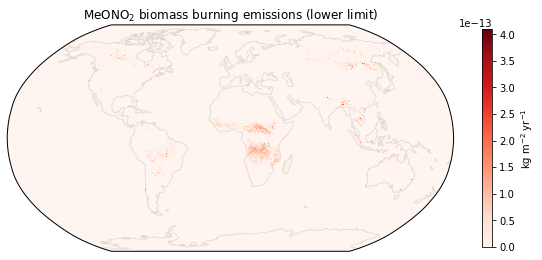

In [11]:
plt_map(gfed_lons, gfed_lats, gfed_meono2_ll.collapsed('time', iris.analysis.SUM).data, '$MeONO_2$')

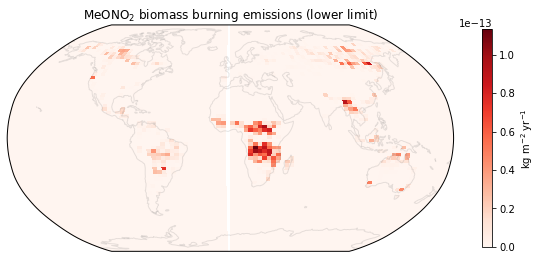

In [12]:
plt_map(ukca_lons, ukca_lats, ukca_meono2_ll.collapsed('time', iris.analysis.SUM).data, '$MeONO_2$')

### Check land mask

In [26]:
# Read UM orography data
ukca_orog = iris.util.squeeze(iris.load_cube(str(path_to_ukca / 'um_orography_xnvtj.nc'), 'OROGRAPHY (/STRAT LOWER BC)'))

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'surface' invalid units 'level'
  warnings.warn(msg)


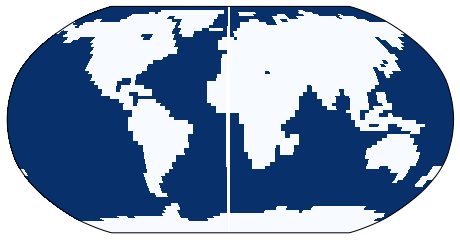

In [27]:
# Mask UKCA heights that are equal to zero
ukca_orog_masked = np.ma.masked_where(ukca_orog.data == 0., ukca_orog.data)
ukca_ocean_mask = ukca_orog_masked.mask # ocean is True

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
ax.pcolormesh(ukca_lons, ukca_lats, ukca_ocean_mask, transform=ccrs.PlateCarree(), cmap='Blues');

In [28]:
ukca_meono2_ll.data.min()

-1.4672363807255452e-15

In [29]:
# Remove negative values and apply UKCA land mask
ukca_ocean_mask_brdcst = np.broadcast_to(ukca_ocean_mask, (12, 73, 96))
ukca_meono2_ll_corrd = np.ma.masked_where((ukca_meono2_ll.data<=0.) & ukca_ocean_mask_brdcst, ukca_meono2_ll.data).filled(fill_value=0.)
ukca_etono2_ll_corrd = np.ma.masked_where((ukca_etono2_ll.data<=0.) & ukca_ocean_mask_brdcst, ukca_etono2_ll.data).filled(fill_value=0.)
ukca_nprono2_ll_corrd = np.ma.masked_where((ukca_nprono2_ll.data<=0.) & ukca_ocean_mask_brdcst, ukca_nprono2_ll.data).filled(fill_value=0.)
ukca_iprono2_ll_corrd = np.ma.masked_where((ukca_iprono2_ll.data<=0.) & ukca_ocean_mask_brdcst, ukca_iprono2_ll.data).filled(fill_value=0.)
ukca_meono2_ul_corrd = np.ma.masked_where((ukca_meono2_ul.data<=0.) & ukca_ocean_mask_brdcst, ukca_meono2_ul.data).filled(fill_value=0.)
ukca_etono2_ul_corrd = np.ma.masked_where((ukca_etono2_ul.data<=0.) & ukca_ocean_mask_brdcst, ukca_etono2_ul.data).filled(fill_value=0.)
ukca_nprono2_ul_corrd = np.ma.masked_where((ukca_nprono2_ul.data<=0.) & ukca_ocean_mask_brdcst, ukca_nprono2_ul.data).filled(fill_value=0.)
ukca_iprono2_ul_corrd = np.ma.masked_where((ukca_iprono2_ul.data<=0.) & ukca_ocean_mask_brdcst, ukca_iprono2_ul.data).filled(fill_value=0.)

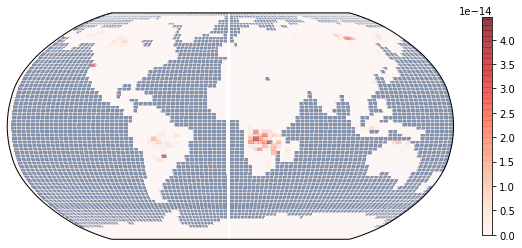

In [33]:
# Overlay UKCA land mask and emission
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
ax.pcolormesh(ukca_lons, ukca_lats, ukca_ocean_mask, transform=ccrs.PlateCarree(), cmap='Blues')
p1 = ax.pcolormesh(ukca_lons, ukca_lats, ukca_meono2_ll_corrd[7,...], transform=ccrs.PlateCarree(), cmap='Reds', alpha=0.5);
fig.colorbar(p1, shrink=0.4);

In [37]:
# Replace unmasked data in a cube with masked data
ukca_meono2_ll.data = ukca_meono2_ll_corrd
ukca_etono2_ll.data = ukca_etono2_ll_corrd
ukca_nprono2_ll.data = ukca_nprono2_ll_corrd
ukca_iprono2_ll.data = ukca_iprono2_ll_corrd
ukca_meono2_ul.data = ukca_meono2_ul_corrd
ukca_etono2_ul.data = ukca_etono2_ul_corrd
ukca_nprono2_ul.data = ukca_nprono2_ul_corrd
ukca_iprono2_ul.data = ukca_iprono2_ul_corrd

### Calculate and compare burdens

In [57]:
gfed_cb_list = [gfed_meono2_ll, gfed_etono2_ll, gfed_nprono2_ll, gfed_iprono2_ll, gfed_meono2_ul, gfed_etono2_ul, gfed_nprono2_ul, gfed_iprono2_ul,
               gfed_grid_cell_area]
for cb in gfed_cb_list:
    for coord in ['latitude', 'longitude']:
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
    cb.coord('latitude').units = 'degrees'
    cb.coord('longitude').units = 'degrees'
def calc_burden_gfed(cb):
    # Calculate emission per grid cell per year
    cb_per_yr = cb.collapsed('time', iris.analysis.SUM)
    # Find area sum per year and multiply it by grid cell area
    cb_per_yr_area_sum = cb_per_yr*gfed_grid_cell_area
    # Calculate burden
    cb_burden = cb_per_yr_area_sum.collapsed(['latitude', 'longitude'], iris.analysis.SUM)
    cb_burden.convert_units('Gg/yr')
    return f'{cb_burden.data:1.2f}, Gg/yr;'

In [58]:
ukca_cb_list = [ukca_meono2_ll, ukca_etono2_ll, ukca_nprono2_ll, ukca_iprono2_ll, ukca_meono2_ul, ukca_etono2_ul, ukca_nprono2_ul, ukca_iprono2_ul]
for cb in ukca_cb_list:
    for coord in ['latitude', 'longitude']:
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
    cb.coord('latitude').units = 'degrees'
    cb.coord('longitude').units = 'degrees'
def calc_burden_ukca(cb):
    # Calculate emission per grid cell per year
    cb_per_yr = cb.collapsed('time', iris.analysis.SUM)
    # Calculate area weights and Earth's area
    area_weights_norm = iris.analysis.cartography.area_weights(cb_per_yr, normalize=True)
    area_weights_inm2 = iris.analysis.cartography.area_weights(cb_per_yr, normalize=False)
    earth_area = iris.cube.Cube(area_weights_inm2.sum(), units='m2')
    # Calculate burden: find area sum per year and multiply it by Earth's area
    cb_per_yr_area_sum = cb_per_yr.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=area_weights_norm)
    cb_burden = cb_per_yr_area_sum*earth_area
    cb_burden.convert_units('Gg/yr')
    return f'{cb_burden.data:1.2f}, Gg/yr;'

In [59]:
print(calc_burden_gfed(gfed_meono2_ll), calc_burden_gfed(gfed_etono2_ll), calc_burden_gfed(gfed_nprono2_ll), calc_burden_gfed(gfed_iprono2_ll))
print(calc_burden_gfed(gfed_meono2_ul), calc_burden_gfed(gfed_etono2_ul), calc_burden_gfed(gfed_nprono2_ul), calc_burden_gfed(gfed_iprono2_ul))

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


22.89, Gg/yr; 15.42, Gg/yr; 1.25, Gg/yr; 8.22, Gg/yr;
290.43, Gg/yr; 199.38, Gg/yr; 10.93, Gg/yr; 40.49, Gg/yr;


In [39]:
print(calc_burden_ukca(ukca_meono2_ll), calc_burden_ukca(ukca_etono2_ll), calc_burden_ukca(ukca_nprono2_ll), calc_burden_ukca(ukca_iprono2_ll))
print(calc_burden_ukca(ukca_meono2_ul), calc_burden_ukca(ukca_etono2_ul), calc_burden_ukca(ukca_nprono2_ul), calc_burden_ukca(ukca_iprono2_ul))

23.24, Gg/yr; 15.67, Gg/yr; 1.25, Gg/yr; 8.22, Gg/yr;
296.86, Gg/yr; 203.81, Gg/yr; 11.16, Gg/yr; 41.22, Gg/yr;


/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


From Simpson et al. (2002):

'...Based on these values, global savanna burning emissions for the five C1–C4 alkyl nitrates reported here are estimated to total roughly 6.6 Gg/yr (mainly as MeONO2) during the flaming stage, and 1.2 Gg/yr (mainly as C2–C4 alkyl nitrates) during the smoldering stage, for a total on the order of 8 Gg/yr (Table 3). For global biomass burning, summedC1–C4 alkyl nitrate emissions on the order of18 Gg/ yr are estimated. In both cases, MeONO2 emissions during the flaming stage comprise a majority (roughly two-thirds) of the total C1–C4 alkyl nitrate emissions. [16] 

The MeONO2 emissions from savanna and global biomass burning are estimated to total roughly 5.4 and 12.6 Gg/yr, respectively (Table 3). By comparison, for an atmos- phere of about 1.7 ? 1020 moles of air, a globally averaged MeONO2 mixing ratio of roughly 2 pptv, and a global MeONO2 lifetime of 0.1 yr, the global MeONO2 source is calculated to be on the order of 300 Gg/yr. That is, MeONO2 released from global biomass burning likely accounts for only a small portion (about 4%) of the global MeONO2 source.'

In [61]:
# Repeat emissions data 10 times along time axis
perpetual_meono2_emis_arr = np.moveaxis(np.tile(np.moveaxis(ukca_meono2_ll.data, 0, -1), 10), -1, 0)
# Create a new time dimention or copy ukca.coord('time') if shapes are the same
if perpetual_meono2_emis_arr.shape == ukca.coord('time').shape:
    time = ukca.coord('time')
else:
    start_date = ukca.coord('time').points[0]
    hours_since_start_date = np.arange(start_date, start_date+10*12*30*24, 720) # montly intervals in hours using 360 day calendar
    time = iris.coords.DimCoord(hours_since_start_date, standard_name='time', var_name='time', units=ukca.coord('time').units)

In [63]:
# Create iris cubes
perpetual_meono2_emis_cb = iris.cube.Cube(perpetual_meono2_emis_arr, long_name='methyl_nitrate_biomass_burning_emission_lower_limit', units='kg/m2/s',
                                          dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])

In [64]:
# Save iris cubes
iris.save(perpetual_meono2_emis_cb, str(path_to_ukca / 'perpetual_meono2_biomass_burning_emissions.nc'))

### Create perpetual year emissions